## Volatility Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import yfinance as yf

In [20]:
adani = yf.download("TATAPOWER.NS", start="2022-06-01", end="2024-06-01")
#adani = yf.Ticker("TATAPOWER.NS")
# get historical market data
#adani_hist = adani.history(period = "2y" )

<ipython-input-20-4198978877>:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  adani = yf.download("TATAPOWER.NS", start="2022-06-01", end="2024-06-01")
[*********************100%***********************]  1 of 1 completed


In [21]:
adani

Price,Close,High,Low,Open,Volume
Ticker,TATAPOWER.NS,TATAPOWER.NS,TATAPOWER.NS,TATAPOWER.NS,TATAPOWER.NS
Date,,,,,
2022-06-01,227.716751,231.092141,225.564329,228.548376,14805104
2022-06-02,229.135391,230.798626,226.298110,226.982970,13296442
2022-06-03,226.053513,231.728090,225.221888,231.189981,11433422
2022-06-06,227.227554,228.548366,222.629196,226.004586,11689465
2022-06-07,229.673508,230.407289,224.781633,225.906758,14994271
...,...,...,...,...,...
2024-05-27,443.993744,450.463780,442.948596,446.830612,10073185
2024-05-28,434.885925,447.328301,432.148603,444.939371,9560161


In [22]:
nifty = yf.download("^NSEI", start="2022-06-01", end="2024-06-01")

<ipython-input-22-647594263>:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty = yf.download("^NSEI", start="2022-06-01", end="2024-06-01")
[*********************100%***********************]  1 of 1 completed


In [23]:
# Step 2: Calculate daily returns
adani['Return'] = adani['Close'].pct_change()
nifty['Return'] = nifty['Close'].pct_change()


In [30]:
# Step 3: Combine and drop NA
returns = pd.merge(adani[['Return']], nifty[['Return']],
                   left_index=True, right_index=True,
                   suffixes=('_Adani', '_Nifty')).dropna()

In [31]:
returns

Price,Return_Adani,Return_Nifty
Ticker,,
Date,,
2022-06-02,0.006230,0.006370
2022-06-03,-0.013450,-0.002628
2022-06-06,0.005194,-0.000889
2022-06-07,0.010764,-0.009246
2022-06-08,-0.007455,-0.003661
...,...,...
2024-05-27,-0.002572,-0.001074
2024-05-28,-0.020513,-0.001932


In [32]:
# Step 4: Fit Isolation Forest
model = IsolationForest(contamination=0.01, random_state=42)

In [33]:
model.fit(returns)

IsolationForest(contamination=0.01, random_state=42)

In [34]:
returns['score'] = model.decision_function(returns)

In [39]:
returns['anomaly'] = model.predict(returns[['Return_Adani', 'Return_Nifty']])

In [41]:
returns

Price,Return_Adani,Return_Nifty,score,anomaly
Ticker,,,,
Date,,,,
2022-06-02,0.006230,0.006370,0.306179,1
2022-06-03,-0.013450,-0.002628,0.272791,1
2022-06-06,0.005194,-0.000889,0.309869,1
2022-06-07,0.010764,-0.009246,0.192774,1
2022-06-08,-0.007455,-0.003661,0.300579,1
...,...,...,...,...
2024-05-27,-0.002572,-0.001074,0.318410,1
2024-05-28,-0.020513,-0.001932,0.254252,1


In [47]:
returns[returns.anomaly == -1]

Price,Return_Adani,Return_Nifty,score,anomaly
Ticker,,,,
Date,,,,
2022-06-13,-0.046688,-0.026380,-0.025495,-1
2022-06-21,0.049513,0.018804,-0.001478,-1
2022-08-30,0.018483,0.025784,-0.010315,-1
2023-12-07,0.107598,-0.001746,-0.007781,-1
2024-02-12,-0.077531,-0.007641,-0.005989,-1


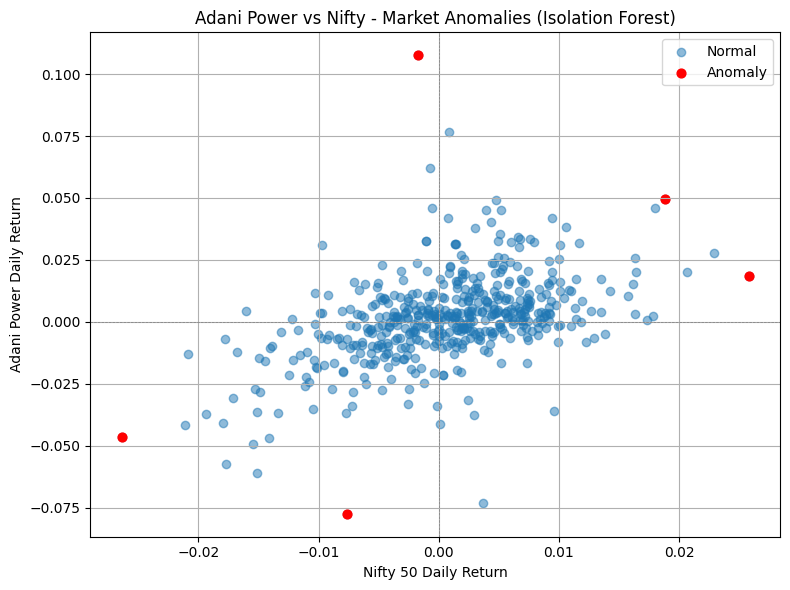

In [42]:
# Step 5: Scatter Plot of Anomalies
plt.figure(figsize=(8,6))
plt.scatter(returns['Return_Nifty'], returns['Return_Adani'], alpha=0.5, label='Normal')
plt.scatter(returns[returns['anomaly'] == -1]['Return_Nifty'],
            returns[returns['anomaly'] == -1]['Return_Adani'],
            color='red', label='Anomaly', s=40)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('Nifty 50 Daily Return')
plt.ylabel('Adani Power Daily Return')
plt.title('Adani Power vs Nifty - Market Anomalies (Isolation Forest)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
